In [1]:
############################################################################################################################
#############################                     convert data into df                    ##################################
############################################################################################################################


import pandas as pd
import numpy as np

# read data as framework

df = pd.read_csv('./data_integer_shift_column.csv')

# check the framework

df.head()

,production,azimuth,md (ft),tvd (ft),footage lateral length,well spacing,porpoise deviation,porpoise count,shale footage,acoustic impedance,...,youngs modulus,isip,breakdown pressure,pump rate,total number of stages,proppant volume,proppant fluid ratio,tc_number,op_number,date_sec
0,5614.947951,-32.279999,19148,6443.0,11966.0,4368.46290,6.33,12,1093,30123.20,...,30.82,4149.0,NaN,83,56,21568792.0,1.23,1,1,1519862400
1,2188.836707,-19.799999,15150,7602.0,6890.0,4714.99220,1.28,4,0,30951.61,...,29.72,5776.0,NaN,102,33,9841307.0,1.47,2,2,1404172800
2,1450.033022,-26.879999,14950,5907.0,8793.0,798.92096,2.03,6,3254,28900.25,...,30.99,4628.0,NaN,88,62,17116240.0,1.67,3,1,1533081600
3,1060.764407,-49.099998,11098,6538.0,4234.0,NaN,6.00,23,7470,32826.08,...,26.20,4582.0,NaN,100,11,3749559.0,0.77,4,1,1325376000
4,607.530385,5.560000,10549,7024.0,2972.0,2967.56300,11.87,9,3637,26740.05,...,31.18,4909.0,NaN,94,9,6690705.0,1.32,5,3,1325376000


In [2]:
df_att = df[['tvd (ft)',
             'well spacing',
             'log permeability',
             'porosity',
             'poisson ratio',
             'p-velocity',
             's-velocity', 
             'youngs modulus', 
             'total number of stages',
             'proppant volume',
             'date_sec',
              'op_number',
             'production']]

In [3]:
#############################################   using KNN to predict the missing data   #####################################################


##############################    scale the data before prediction

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_att_sc = pd.DataFrame(scaler.fit_transform(df_att), columns = df_att.columns)
# df_sc.head()


##############################    KNN prediction

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_sc_knn = pd.DataFrame(imputer.fit_transform(df_att_sc),columns = df_att_sc.columns)

df_sc_knn.isna().sum().sum()

0

In [4]:
x = df_sc_knn.drop(['production'], axis=1)

y = df_sc_knn['production'].values.reshape(-1, 1)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [6]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(x_train)
y_scaler = StandardScaler().fit(y_train)


x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)



from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(x_train_scaled, y_train_scaled)

print(model.intercept_)

[-1.72270096e-16]


In [7]:
print(model.coef_)

[[ 0.28902198  0.06398879 -0.06217998 -0.12671409  0.18438594 -0.29657767
   0.11753052 -0.46383292  0.21639418  0.3648924   0.10091176 -0.05412158]]


In [11]:
pd.DataFrame(model.coef_[0], x.columns, columns = ['Coeff'])

,Coeff
tvd (ft),0.289022
well spacing,0.063989
log permeability,-0.062180
porosity,-0.126714
poisson ratio,0.184386
p-velocity,-0.296578
s-velocity,0.117531
youngs modulus,-0.463833
total number of stages,0.216394
proppant volume,0.364892


In [12]:
predictions = model.predict(x_test_scaled)

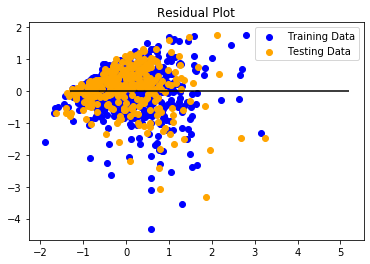

In [13]:
import matplotlib.pyplot as plt


plt.scatter(model.predict(x_train_scaled), model.predict(x_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(x_test_scaled), model.predict(x_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(x_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.49809604253421486, R2: 0.5403438309077999


Text(0.5, 1.0, 'Hist Plot')

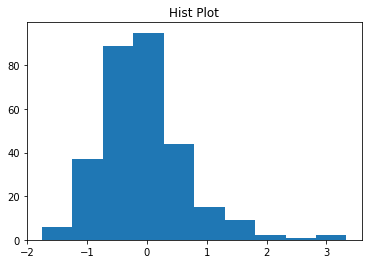

In [15]:
plt.hist(y_test_scaled - predictions)
plt.title("Hist Plot")

In [16]:
from sklearn import metrics
metrics.mean_absolute_error(y_test_scaled, predictions)

0.5250892649072162